In [1]:
from platform import python_version
print(python_version())

3.8.0


In [13]:
import numpy as np
import pprint
import pickle  # for saving objects to file and loading them later
import os
import matplotlib.pyplot as plt
import csv
import tree_builder
import random
import matplotlib.colors as colors

pp = pprint.PrettyPrinter(compact=False)

EXPERIMENT = 1

MODEL_TYPE = 'recursive' # we tested various value function, this is the final form used in the paper

# to be used as a function decorator for storing the results of expensive function calls 
# and returning the cached result when the same inputs occur again    
def memoize(function):    
    memo = {}
    def wrapper(*args):
        if args not in memo:
            memo[args] = function(*args)
        return memo[args]
    return wrapper


# generates zero probabilities if tau=0.1: 
# TAUS = [0.1000, 0.1413, 0.1996, 0.2820, 0.3984, 0.4735, 0.5628, 0.6690, 0.7952, 0.9451, 1.3353, 1.8864, 3.1678, 4.4754, 6.3227, 8.9326]

TAUS   = np.geomspace(0.2, 8, 12)
GAMMAS = [0.99, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.6, 0.5, 0.4, 0.2, 0] # np.linspace(0, 1, 14)
BETAS  = np.geomspace(0.1, 2, 10)
KAPPAS = np.linspace(0, 1, 11)

# parameters for the sampling MCTS model - grid coverage is similar to geomspace, but integer
BUDGET = [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 16, 20, 30, 40, 70, 100, 200, 500, 1000]
EXPLORE_C = [ 1, 2, 3, 4, 5, 7, 9, 11, 14, 18, 26, 35] 
            # the optimal exploration c increases with budget, for budget=1000 optimal c = 26

# bit threshold for information-theorethic model of (cheyette & piantodosi 2022)
Bs = [0.1, 0.5, 1, 1.5, 2, 2.5, 3, 3.6, 4.2, 5, 6, 10]

# comment models from this list to re-generate only modles that changed -- 
MODEL_NAMES = ['Expected_Utility', 'Discounted_Utility', 'Probability_Weighted_Utility', 'PW_DU',
               'Heuristic_Steps', 'Heuristic_Cells', 'Heuristic_Steps_Cells', 'Random', 
               #'Sampling']#, # this model is generated from sample_model.py, it is very slow!
               'EU_Numerosity', 'DU_Numerosity', 'Steps_Numerosity', 'Cells_Numerosity', 'Steps_Cells_Numerosity'] 

MODEL_NAMES_ABREV = {'Expected_Utility': 'EU', 
                     'Discounted_Utility': 'DU',
                     'Probability_Weighted_Utility': 'PW',
                     'PW_DU': 'PW_DU',
                     'Heuristic_Steps': 'HS',
                     'Heuristic_Cells': 'HC',
                     'Heuristic_Steps_Cells': 'HSC',
                     'Random': 'Rand',
                     'Sampling': 'SM',
                     'EU_Numerosity' : 'EU_Num', 
                     'DU_Numerosity' : 'DU_Num',
                     'Steps_Numerosity': 'HS_Num',
                     'Cells_Numerosity': 'HC_Num',
                     'Steps_Cells_Numerosity': 'HSC_Num'
                    }

# which parameter ranges should be fitted to each model
MODEL2PARAMS = {
                'Expected_Utility': [(round(tau,3), 1, 1) for tau in TAUS],
                'Discounted_Utility': [(round(tau,3), round(gamma,3), 1) for tau in TAUS for gamma in GAMMAS],
                'Probability_Weighted_Utility': [(round(tau,3), 1, round(gamma,3)) for tau in TAUS for gamma in BETAS],
                'PW_DU': [(round(tau,3), round(gamma,3), round(beta,3)) for tau in TAUS for gamma in GAMMAS for beta in BETAS],
                'Heuristic_Steps': [(round(tau,3), 1) for tau in TAUS],
                'Heuristic_Cells': [(round(tau,3), 0) for tau in TAUS],
                'Heuristic_Steps_Cells': [(round(tau,3), round(kappa,3)) for tau in TAUS for kappa in KAPPAS],
                'Random': [(1,)],
                'Sampling': [(bdgt, c) for bdgt in BUDGET for c in EXPLORE_C],
                'EU_Numerosity': [(round(tau,3), 1, 1, b) for tau in TAUS for b in Bs],
                'DU_Numerosity': [(round(tau,3), round(gamma,3), 1, b) for tau in TAUS for gamma in GAMMAS for b in Bs],
                'Steps_Numerosity': [(round(tau,3), 1, b) for tau in TAUS for b in Bs],
                'Cells_Numerosity': [(round(tau,3), 0, b) for tau in TAUS for b in Bs],
                'Steps_Cells_Numerosity': [(round(tau,3), round(kappa,3), b) for tau in TAUS for kappa in KAPPAS for b in Bs]
               }

# which function should be called for each model
# if you see error 'name 'node_value_plan' is not defined' - look for a cell below that defines it
MODEL2RAWNODEVAL = {
                'Expected_Utility': node_value_plan,
                'Discounted_Utility': node_value_plan,
                'Probability_Weighted_Utility': node_value_plan,
                'PW_DU': node_value_plan,
                'Heuristic_Steps': node_value_heuristic,
                'Heuristic_Cells': node_value_heuristic,
                'Heuristic_Steps_Cells': node_value_heuristic,
                'Random': node_value_random,
                'EU_Numerosity': node_value_plan,
                'DU_Numerosity': node_value_plan,
                'Steps_Numerosity': node_value_heuristic,
                'Cells_Numerosity': node_value_heuristic,
                'Steps_Cells_Numerosity': node_value_heuristic
                }



In [14]:
# tree is generated from maze maps using tree_builder.py
# needs to be only generated once per experiment

d = os.getcwd() + f'/__experiment_{EXPERIMENT}/pickled_data/tree.pickle'

# this is <class 'dict'>, with entries for each maze, TREE[maze_name]
with open(d, 'rb') as handle:
    TREE = pickle.load(handle)


# which mazes are in the tree 
for maze_name in TREE:
    print(maze_name) 
    
# this is a table maps each bit threshold B and number n to an information-theoretic perceived number k
with open(os.getcwd() + '/Q_k_n.pickle', 'rb') as handle:
    numerosity_table = pickle.load(handle)    


Equal_2vs5_mirror
3ways_2_mirror
Equal_10vs2_mirror
6vs1_2_mirror
Equal_10vs2
Equal_6vs3
Loop_2_mirror
Equal_4vs2
4ways
Equal_6vs6
Equal_8vs3
Equal_7vs9_mirror
Equal_2vs5
Equal_7vs9
6vs2
Equal_8vs8_mirror
4vs1
Equal_7vs2
Equal_7vs2_mirror
Equal_8vs3_mirror
4ways_mirror
3ways_3_mirror
Equal_4vs2_mirror
Loop_2
Loop_1_mirror
3ways_4_mirror
Loop_1
Equal_6vs3_mirror
4vs1_mirror
3ways_4
Equal_6vs6_mirror
3ways_1_mirror
6vs1_2
6vs2_mirror
3ways_1
Equal_8vs8
3ways_3
6vs1_1
3ways_2
6vs1_1_mirror


# Calculating values for all models except Sampling

This needs to be done every time a model is updated for the models which have changed.
Try not to regenerare models with 3 parameters if not necessary, they can take a long time

In [4]:
def softmax(values, tau):
    """ small values are better
    large tau converges to random agent """

    numer = [np.exp(-v * (1/tau)) for v in values]
    denom = sum(numer)
    return [n/denom for n in numer]


def weight(p, beta):
    """ probability weighting function: convert probability p to weight """
    # return p**beta / (p**beta + (1-p)**beta) ** (1/beta)
    if p == 0:
        return 0 # just to avoid runtime warning np.exp(np.log(0)) still returns 0
    return np.exp( -1 * (-np.log(p))**beta )



@memoize
def node_value_plan(maze_name, nid, gamma=1, beta=1, bit_threshold = -1):
    """ compute value BEFORE softmax """
    value, p_exit, steps_to_exit, min_child_value = 0, 0, 0, 0

    tree = TREE[maze_name]
    steps_to_node = tree[nid]['steps_from_par']
        
    if MODEL_TYPE == 'original_rldm':
        steps_to_node = tree[nid]['steps_from_root']
    
    # if using numerosity transformations, transform all variables that reflect numbers of cells
    if bit_threshold!= -1:
        steps_to_node = numerosity_table[bit_threshold][steps_to_node]
        
    # get steps_to_exit if nid is not root
    if tree[nid]["pid"] not in {"NA", None}:

        n_black_cells_total = tree[tree[nid]["pid"]]["remains"]
        cell_distances = tree[nid]["celldistances"]
        n_cells_open = len(cell_distances)
        
        if isinstance(list(cell_distances)[0], tuple): #  tree builer
            r,c = tree[nid]["pos"]
            cell_distances = [abs(r-rr) + abs(c-cc) for rr,cc in cell_distances]
            
        
        # if using numerosity transformations, transform all variables that reflect numbers of cells
        if bit_threshold!= -1:
            n_cells_open = numerosity_table[bit_threshold][n_cells_open]
            n_black_cells_total = numerosity_table[bit_threshold][n_black_cells_total]
            cell_distances = [ numerosity_table[bit_threshold][c] for c in cell_distances]
        
        # expected number of steps from making observation to exit, if it is seen
        steps_to_exit = np.mean(cell_distances)
        
        # probability that the exit is in the current room is the ratio of cells in the current room
        # to total cells that remain unseen in the maze
        p_exit = n_cells_open/n_black_cells_total
        

    # get min_child_value 
    if tree[nid].get("children", []):
        min_child_value = float("inf") # if nid is a leaf

        for cid in tree[nid]["children"]:
            child_value = node_value_plan(maze_name, cid, gamma, beta)
            if child_value < min_child_value:
                min_child_value = child_value

    # how the value function was originally implemented, including in RLDM and all previous papers
    if MODEL_TYPE == 'original_rldm':
        value = weight(p_exit, beta) * (steps_to_node + steps_to_exit) \
                + gamma * weight(1-p_exit, beta) * min_child_value

    # this is the improved formulation of the value function that works with sub-trees recursively
    # updated in Spring 2022
    # optimal expected utility is not affected, but it affects models with gamma < 1 and beta != 1 
    elif MODEL_TYPE == 'recursive': 
        value = steps_to_node + weight(p_exit, beta) * steps_to_exit \
                + gamma * weight(1-p_exit, beta) * min_child_value


    return value


# @memoize
def node_value_heuristic(maze_name, nid, kappa=1, bit_threshold = -1):
    ''' if 0<kappa<1 this is steps-cells heuristic, '''
    ''' if kappa=1 this is a steps heuristic '''
    ''' if kappa=0 this is a cells heuristic '''

    tree = TREE[maze_name]
    steps = tree[nid]["steps_from_par"]
    cells = len(tree[nid]["celldistances"])
    
    if bit_threshold!= -1:
        steps = numerosity_table[bit_threshold][steps]
        cells = numerosity_table[bit_threshold][cells]

    return steps*kappa - cells*(1-kappa)


def node_value_random(maze_name, nid):

    tree = TREE[maze_name]

    pid = tree[nid]["pid"]
    return 1/len(tree[pid]['children'])


# returns all values for given maze
def node_values(maze_name, parameters, value_func):

    tree = TREE[maze_name]
    values_summary = {} # {nid: {(param): {cid: value, cid: value, ...}}}

    for nid in tree:

        if nid == 'root':
            continue

        children = tree[nid]['children']

        # ignore nid if it's not a decision node
        if len(children) <= 1:
            continue

        values_summary[nid] = {}

        for tau, *params in parameters: # what is *???

            raw_values = [ value_func(maze_name, cid, *params) for cid in children ]
            values = softmax(raw_values, tau)

            values_summary[nid][(tau, *params)] = {cid: val for cid,val in zip(children, values)}

    return values_summary


# generate values for all models and mazes
def pickle_node_values():

    if not os.path.exists(f'__experiment_{EXPERIMENT}/node_values_{MODEL_TYPE}'):
        os.makedirs(f'__experiment_{EXPERIMENT}/node_values_{MODEL_TYPE}')

    for model_name in MODEL_NAMES:

        parameters = MODEL2PARAMS[model_name]
        node_value_func = MODEL2RAWNODEVAL[model_name]

        print(f'{model_name} ....')

        if not os.path.exists(f'__experiment_{EXPERIMENT}/node_values_{MODEL_TYPE}/{model_name}'):
            os.makedirs(f'__experiment_{EXPERIMENT}/node_values_{MODEL_TYPE}/{model_name}')

        for params in parameters:

            values_summary = {} # {maze_name: {nid: {cid: val, ...}}

            for maze_name in TREE:

                if 'practice' in maze_name:
                    continue

                values_summary[maze_name] = node_values(maze_name, [params], node_value_func)

            # this saves a separate .pickle file for each combination of parameters, 
            # where each file contains all mazes and all nodes
            with open(f'__experiment_{EXPERIMENT}/node_values_{MODEL_TYPE}/{model_name}/node_values_{tuple(round(p,3) for p in params)}.pickle', 'wb') as handle:
                pickle.dump(values_summary, handle, protocol=pickle.HIGHEST_PROTOCOL)

        print(model_name, 'done!')

# Generating values into pickle 
# Delete everything in the pickle directory before doing this 

Run when models or parameters updated

In [ ]:
print(f'generating values into pickle Experiment: {EXPERIMENT}, Model Type: {MODEL_TYPE}')
pickle_node_values()

# Visualisation

In [7]:
import sample_model

def best_paths(maze_name, param, node_value_func, exit_pos=None):
    """ return list of all best paths with corresponding value """

    tree = TREE[maze_name]
    
    nid, nodes_paths = 0, []
    values_summary = models.node_values(maze_name, [param], node_value_func)

    agenda = [([0], 0)]

    while agenda:
        path, path_value = agenda.pop(0)
        nid = path[-1]

        observations = tree[nid]['celldistances']
        children = tree[nid]['children']

        if exit_pos in observations or len(children) == 0:
            nodes_paths.append((path, path_value))

        elif len(children) == 1:
            _nid = next(iter(children))
            agenda.append((path + [_nid], path_value))

        else:
            max_value = max(values_summary[nid][param].values())
            path_value += np.log(max_value)
            best_children = [cid for cid,val in values_summary[nid][param].items() if val == max_value]

            for cid in best_children:
                agenda.append((path + [cid], path_value))

    return nodes_paths


def rotate_maze(maze):
    """ modify code so for any rotation/reflection """

    # flip up-down
    # maze = maze[::-1]

    # flip wrt diagonal
    # maze = maze[::-1]
    # maze = list(zip(*maze))

    # flipt left-right
    maze = [row[::-1] for row in maze]

    print('\n'.join([''.join([str(cell) for cell in row]) for row in maze]))


def assign_random_exit(maze):

    black_positions = []

    for r,row in enumerate(maze):
        for c,cell in enumerate(row):
            black_positions += [(r,c)] if cell==0 else []

    r, c = random.choice(black_positions) # exit position
    maze[r][c] = 2

    pp.pprint(maze)



def visualize_path(maze, path, path_name=None, ax=None):
    
    nrows = len(maze)

    if ax is None:
        _, ax = plt.subplots(1)

    path = [(c,r) for r,c in path]
    x, y = zip(*[(x + 0.5, nrows - y - 0.5) for x,y in path])
    ax.plot(x, y, 'o--',  markersize=4, label=path_name, alpha=0.7)
    ax.plot(x[0], y[0], 's', markersize=5, color='purple')


# generate a figure for what one model does in a given node
def visualize_nodevalues(maze_name, pid, parameters, param_indx, node_value_func, model_name, ax=None):

    tree = TREE[maze_name]

    if ax is None:
        _, ax = plt.subplots(1)

    values_summary = node_values(maze_name, parameters, node_value_func)

    decision_summary = {nid: [] for nid in tree[pid]['children']}

    for param in parameters:
        for nid, val in values_summary[pid][param].items():

            decision_summary[nid].append(val)

    for nid, values in decision_summary.items():
        ax.plot([param[param_indx] for param in parameters], values, 'o--', markersize=3, label=nid, alpha=0.7)
        ax.set_ylim(0,1)
    
    ax.set_title(model_name)
    ax.grid()
    #ax.legend() # uncomment if you want the little plot to show coloured legen for each node in the corner 


def visualize_nodevalues_samplemodel(maze_name, pid, parameters, ax=None):

    if ax is None:
        _, ax = plt.subplots(1)

    decision_summary = {}
    explore_c = 11

    
    for budget, _ in parameters:
        with open(f"__experiment_{EXPERIMENT}/node_values_recursive/Sampling/node_values_{budget, explore_c}.pickle", "rb") as handle:
            node_values_summary = pickle.load(handle) # world: {pid: {(param,): {nid1: value, nid2: value}}}

        for nid, val in node_values_summary[maze_name][pid][budget, explore_c].items():
            decision_summary.setdefault(nid, []).append(val)

    for nid, values in decision_summary.items():
        ax.plot([param[0] for param in parameters], values, 'o--', markersize=3, label=nid, alpha=0.7)
        ax.set_ylim(0,1)
    
    ax.set_title('Sample Based')
    ax.grid()
    ax.legend()


# this generates a simulation of what each model does in a given tree node
def visualize_path_and_nodevalues(maze_name, pid):

    tree = TREE[maze_name]

    fig, axs = plt.subplots(3,3)
    axs = axs.flat

    maze, exit_pos = read_maze(maze_name, EXPERIMENT)

    if pid != 0:
        # if pid=0, then tree[pid] doesn't have a map key
        # process map to reflect what's been observed

        maze = tree[pid]['map']
        maze = tree_builder.update_map(maze, old_pos=tree[tree[pid]['pid']]['pos'], new_pos=tree[pid]['pos'])

    # draw maze and decision paths
    exit_pos = None

    visualize_maze(maze, exit_pos, axs[0])

    for nid in tree[pid]['children']:
        # path = tree[nid]['path_from_root']
        path = tree[nid]['path_from_par']
        visualize_path(maze, path, path_name=None, ax=axs[0])

    # node value plot for each model

    parameters = [(tau,1,1) for tau in TAUS]
    visualize_nodevalues(maze_name, pid, parameters, 0, node_value_plan, 'Expected Utility', axs[1])

    #DU tau = 1.0768355 gamma = 0.4664486
    parameters = [(1,gamma,1) for gamma in GAMMAS]
    visualize_nodevalues(maze_name, pid, parameters, 1, node_value_plan, 'Discounted Utility', axs[2])
    
    
    parameters = [(1,1,beta) for beta in BETAS]
    visualize_nodevalues(maze_name, pid, parameters, 2, node_value_plan, 'Probability Weighted', axs[3])

    # Sampling
    #parameters = [(bdgt, 2) for bdgt in BUDGET]
    #visualize_nodevalues_samplemodel(maze_name, pid, parameters, axs[4])
    
    #DU-Num tau = 0.8112561 gamma=0.4185981 beta=1.0000000   bits=4.919813
    parameters = [(0.8, 0.42, 1, bits) for bits in Bs]
    visualize_nodevalues(maze_name, pid, parameters, 3, node_value_plan, 'DU Numerosity', axs[4])
    
    parameters = [(1,1,1,bits) for bits in Bs] 
    visualize_nodevalues(maze_name, pid, parameters, 3, node_value_plan, 'EU Numerosity', axs[5])
   
    # k = 0.7
    parameters = [(1,k) for k in KAPPAS] 
    visualize_nodevalues(maze_name, pid, parameters, 1, node_value_heuristic, 'Steps-Cells', axs[6])

    parameters = [(1,0.7, bits ) for bits in Bs] 
    visualize_nodevalues(maze_name, pid, parameters, 2, node_value_heuristic, 'Steps-Cells-Num', axs[7])
    
    parameters = [(1.4, 0.68, beta ) for beta in BETAS] 
    visualize_nodevalues(maze_name, pid, parameters, 2, node_value_plan, 'PW-DU', axs[8])

    plt.tight_layout()
    return fig, axs



def visualize_nodes_path(maze_name, nodes_path, ax=None):

    tree = TREE[maze_name]
    maze, exit_pos = read_maze(maze_name, EXPERIMENT)

    def rand_jitter(arr):
        """ given array, jitter the values so that same values don't overlap """
        stdev = .02 * (max(arr) - min(arr))
        return arr + np.random.randn(len(arr)) * stdev

    if ax is None:
        _, ax = plt.subplots(1)

    exit_pos = None

    visualize_maze(maze, exit_pos, ax)

    for nid in nodes_path:

        path = tree[nid]['path_from_par']
        if path:
            row_vals, col_vals = zip(*path)
            path = [(r,c) for r,c in zip(rand_jitter(row_vals), rand_jitter(col_vals))]
            visualize_path(maze, path, path_name=nid, ax=ax)

    ax.legend(loc='upper left', bbox_to_anchor=(1,1))


def visualize_popular_subject_nodes_paths(maze_name):

    fig, axs = plt.subplots(2,2)
    axs = axs.flat

    with open(f'__experiment_{EXPERIMENT}/trees/{maze_name}.pickle', 'rb') as handle:
        tree = pickle.load(handle)

    with open(f"__experiment_{EXPERIMENT}/pickled_data/subject_decisions.pickle", "rb") as handle:
        decisions = pickle.load(handle)

    subject_paths_count = {} # {nodes path: count}

    # collect popular paths
    for sid in decisions:
        nodes_path = tuple(decisions[sid][maze_name]['nodes'])

        if nodes_path not in subject_paths_count:
            subject_paths_count[nodes_path] = 0

        subject_paths_count[nodes_path] += 1

    subject_paths_count = [(count, nodes_path) for nodes_path, count in subject_paths_count.items()]
    subject_paths_count.sort(reverse=True)

    for indx, (count, nodes_path) in enumerate(subject_paths_count[:4]):
        visualize_nodes_path(maze_name, nodes_path, ax=axs[indx])
        axs[indx].set_title(count)
    
    fig.suptitle(maze_name)


def visualize_all_path_by_subject(sid):

    fig, axs = plt.subplots(3,4)
    axs = axs.flat

    with open(f"__experiment_{EXPERIMENT}/pickled_data/subject_decisions.pickle", "rb") as handle:
        decisions = pickle.load(handle)

    for indx, maze_name in enumerate(decisions[sid]):
        if indx >= 12:
            break
        
        nodes_path = decisions[sid][maze_name]['nodes']
        visualize_nodes_path(maze_name, nodes_path, ax=axs[indx])
        axs[indx].set_title(maze_name)

    fig.suptitle(sid)


def visualize_all_best_paths(maze_name, model_name, param):

    fig, axs = plt.subplots(2,3,constrained_layout=True)
    axs = axs.flat

    nodes_paths = best_paths(maze_name, param, models.MODEL2RAWNODEVAL[model_name], exit_pos)
    pp.pprint(nodes_paths)

    for (nodes_path, path_value), ax in zip(nodes_paths, axs):
    
        visualize_maze(maze, ax=ax) 
        visualize_nodes_path(maze_name, nodes_path, ax=ax)
        ax.set_title(f'{model_name} | {param} | {round(path_value,3)}')

    fig.suptitle(maze_name)
    plt.show()

In [8]:
def visualize_maze(maze, exit_pos=None, ax=None):

    nrows, ncols = len(maze), len(maze[0])

    if ax is None:
        _, ax = plt.subplots(1)

    # custom color map
    cmap = colors.ListedColormap(['black', # black tiles
                                  'white', 
                                  'black', # 'red' if you want to see exit, 'black' if you want to hide it
                                  '#8B2323', # brown4, wall
                                  'white', 
                                  '#7FFFD4', #'#a1c38c', # entrance
                                  'white', # white cells
                                  'white'])
    
    boundaries = [0, 1, 2, 3, 4, 5, 6, 7]
    norm = colors.BoundaryNorm(boundaries, cmap.N, clip=False)

    # assign exit pos if we give one
    maze = [[cell for cell in row] for row in maze]
    if exit_pos:
        r,c = exit_pos
        maze[r][c] = 2

    # XXX fix orientation
    maze = [[int(cell) for cell in list(row)[:ncols]] for row in maze][::-1]

    # draw maze
    ax.pcolormesh(maze, edgecolors='lightgrey', linewidth=1, cmap=cmap, norm=norm)
    ax.set_aspect('equal')

    ax.axis('off')

In [9]:
def read_maze(maze_name, exp):

    with open(f'__experiment_{exp}/mazes/{maze_name}.txt', 'r') as f:
        ncols = int(f.readline())
        nrows = int(f.readline())
        maze = f.readlines()
    
    # preprocessing of maze from text
    maze = tuple([tuple([int(cell) for cell in row.split('\n')[0]]) for row in maze])

    exit_pos = None

    for r,row in enumerate(maze):
        for c,cell in enumerate(row):
            if cell == 2:
                exit_pos = (r,c)
    
    return maze, exit_pos

def simulate_model_path(maze_name, experiment, model, params) :

    with open(f'__experiment_{experiment}/node_values_recursive/{model}/node_values_{params}.pickle', 'rb') as handle:
       values_to_simulate = pickle.load(handle)

    maze_map, exit_pos = read_maze(maze_name, experiment)
    nid, path = 0, [0]

    while True:

        nid = path[-1] # set nid to the last element of path

        observations = TREE[maze_name][nid]['celldistances'] # this is a set, for example {(2, 4), (2, 2)}, or an empty set, if nid is root
        children = list(TREE[maze_name][nid]['children'])

        if exit_pos in observations or len(children) == 0:
            return path # exit reached, returning sequence of numeric node ids, for example [0, 1, 3]
            break

        elif len(children) == 1:
            _nid = next(iter(children)) # degenerate node, select immediate successor
            path.append(_nid)

        else:
            probabilities = [values_to_simulate[maze_name][nid][params][cid] for cid in children]
            _nid = random.choices(children, probabilities, k=1)[0]
            path.append(_nid)

1
{0: {(1, 1, 1, 0.1): {1: 0.30462668536095827, 2: 0.6953733146390417}, (1, 1, 1, 0.5): {1: 0.2560321654297796, 2: 0.7439678345702204}, (1, 1, 1, 1): {1: 0.281175415691137, 2: 0.718824584308863}, (1, 1, 1, 1.5): {1: 0.29959969276874826, 2: 0.7004003072312518}, (1, 1, 1, 2): {1: 0.31529928087888526, 2: 0.6847007191211146}, (1, 1, 1, 2.5): {1: 0.3283520229015669, 2: 0.671647977098433}, (1, 1, 1, 3): {1: 0.33578752588963284, 2: 0.6642124741103672}, (1, 1, 1, 3.6): {1: 0.34241873369319104, 2: 0.6575812663068089}, (1, 1, 1, 4.2): {1: 0.3406132730001727, 2: 0.6593867269998273}, (1, 1, 1, 5): {1: 0.33779057043140603, 2: 0.662209429568594}, (1, 1, 1, 6): {1: 0.3392436827854004, 2: 0.6607563172145997}, (1, 1, 1, 10): {1: 0.3392436827854004, 2: 0.6607563172145997}}}


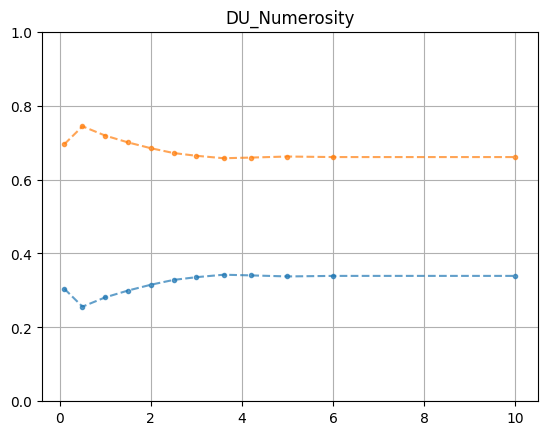

In [15]:
# plot a model's prediction in a specific maze and node

maze_name = 'Equal_4vs2_mirror' # maze from Experiment 1
print(EXPERIMENT)

maze, exit_pos = read_maze(maze_name, 1) 


# -----------------------------
# visualize_path_and_nodevalues
# -----------------------------

pid = 0
parameters = [(1,1,1,bits) for bits in Bs] 
values_summary = node_values(maze_name, parameters, node_value_plan)
print(values_summary)
visualize_nodevalues(maze_name, pid, parameters, 3, node_value_plan, 'DU_Numerosity', ax=None)
 

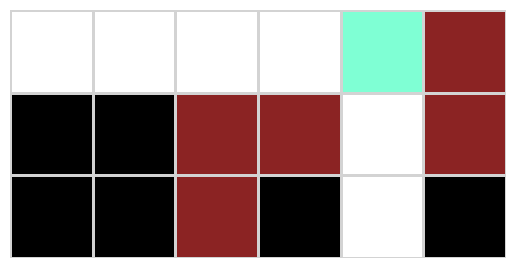

Node 1 (0.7 subjects) | Node 2 (0.3 subjects)
1 [(0, 4), (1, 4), (2, 4)]
2 [(0, 4), (0, 3), (0, 2), (0, 1)]


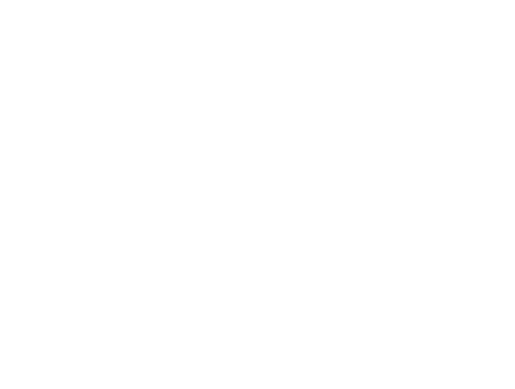

In [16]:
# -----------------------------
# visualize maze map
# -----------------------------

maze_name = 'Equal_4vs2_mirror'
maze, exit_pos = read_maze(maze_name, EXPERIMENT)
    
fig, ax = plt.subplots(1)
visualize_maze(maze, ax=ax)
plt.savefig(maze_name+".png", bbox_inches='tight')

plt.show()
plt.axis('off')
ax.axis('off')

pid = 0

with open(f'__experiment_{EXPERIMENT}/pickled_data/node_values_Humans.pickle', 'rb') as handle:
         node_stats = pickle.load(handle)

sup_title = ' | '.join([f"Node {nid} ({node_stats.get((maze_name, nid), {}).get('ratio', 0)} subjects)" 
                             for nid in TREE[maze_name][pid]['children']])

print(sup_title)
for nid in TREE[maze_name][pid]['children']:
    path = TREE[maze_name][nid]['path_from_par']
    print(nid, path)
    visualize_path(maze, path, path_name=nid, ax=ax)# does not work

ax.set_title(sup_title)
ax.legend()
plt.show()

Loop_1_mirror
Loop_1
3ways_2_mirror
3ways_2


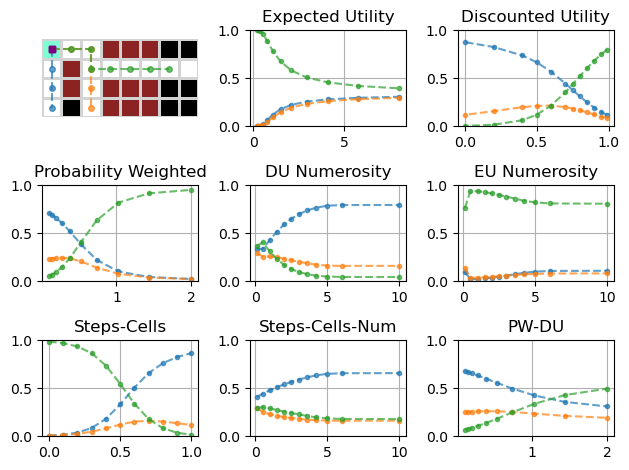

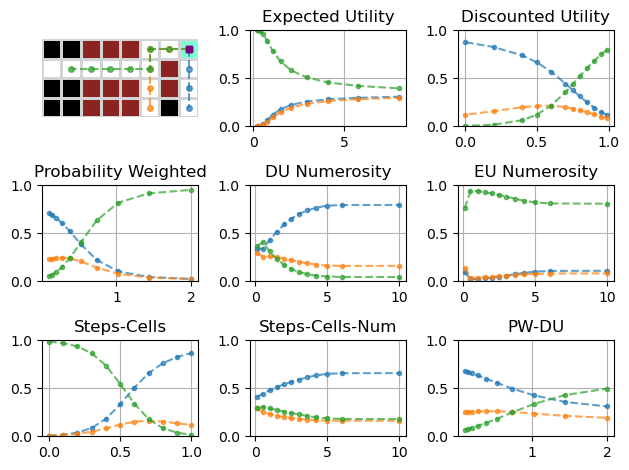

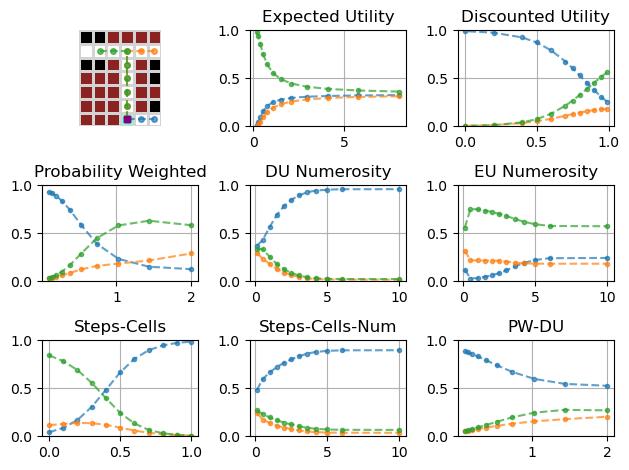

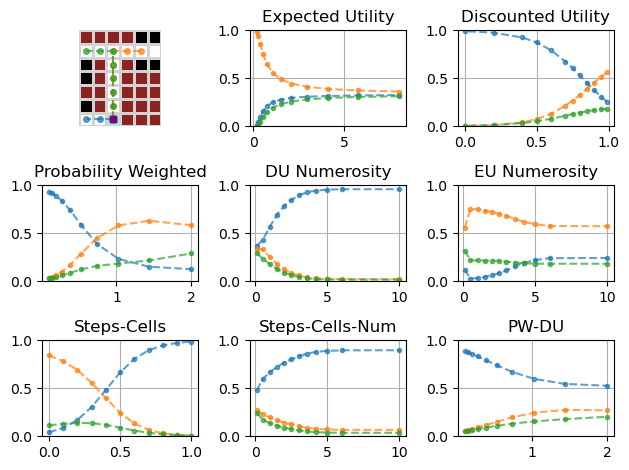

In [18]:
# debugging -- for several mazes simulate paths taken by all models

mazes_e1 = ("Loop_1_mirror", "Loop_1", "3ways_2_mirror", "3ways_2" )
# iterate through all mazes in the directory and generate a simulation figure for them


#for pid in range(11,21):
for maze_name in mazes_e1: #TREE: 

    print(maze_name)
    maze, exit_pos = read_maze(maze_name, 1)

    # -----------------------------
    # visualize_path_and_nodevalues
    # -----------------------------

    #pid=

    # print human stats if available
    #with open(f'__experiment_{EXPERIMENT}/pickled_data/node_values_Humans.pickle', 'rb') as handle:
    #    node_stats = pickle.load(handle)

    #sup_title = ' | '.join([f"Node {nid} ({node_stats.get((maze_name, nid), {}).get('count', 0)} subjects)" 
    #                        for nid in TREE[maze_name][pid]['children']])
    #print(sup_title)

    visualize_path_and_nodevalues(maze_name, pid)
    plt.savefig(maze_name + "_simulation.png", bbox_inches='tight')


# saving data to .csv for importing into R

In [ ]:
# generate random IDs of the form Nxxxxx for all nodes in the tree
# guarantees uniqueness of each ID
# this is how we originally saved the nodes into .csv, no other reason to have these IDs instead of numbers
def node_id_conversion():
    random.seed(0)
    unique_ids = list(range(10000, 100000))
    random.shuffle(unique_ids)

    int_2_nodeid = {}

    id_indx = 0
    for world in TREE:
        for nid in TREE[world]:
            int_2_nodeid[world,nid] = f'N{unique_ids[id_indx]}'
            id_indx += 1
    
    return int_2_nodeid


# converting the pickled tree into a .csv tree used by the model fitting code in R 
def tree_builder_to_csv():
    
    # int node id to string node id
    int_2_nodeid = node_id_conversion()

    col_names = ['world', 'nodeLocation', 'NID', 'PARENTID', 'pathFromParent', 'depth', 'N', 'S', 'stepsFromRoot', 'isLeaf', 'nodeValue', 'nodeEP', 'blackremains', 'cellDistances']

    # collect data

    rows = []

    for world in TREE:
        for nid in TREE[world]:

            if nid == 'root':
                continue

            pid = 'NA' if TREE[world][nid]['pid'] is None else int_2_nodeid[world, TREE[world][nid]['pid']]

            node_location = TREE[world][nid]['pos'][::-1]

            path_from_par = ''.join([ f'p{pos[::-1]};' for pos in TREE[world][nid]['path_from_par'] ])

            steps_from_par = TREE[world][nid]['steps_from_par']

            steps_from_root = TREE[world][nid]['steps_from_root']

            is_leaf = 'FALSE' if TREE[world][nid]['children'] else 'TRUE'

            black_remains = TREE[world][nid]['remains']

            cell_distances = [(x,y) for y,x in TREE[world][nid]['celldistances']]

            cell_distances = sorted([ abs(node_location[0]-black_location[0]) +  abs(node_location[1]-black_location[1])
                                    for black_location in cell_distances])

            cell_distances = ', '.join(str(val) for val in cell_distances)

            blacks_revealed = len(TREE[world][nid]['celldistances'])
            
            depth = TREE[world][nid]['depth']

            # 0 in place of None
            row = [world, node_location, int_2_nodeid[world,nid], pid, path_from_par, depth, blacks_revealed, steps_from_par, 
                        steps_from_root, is_leaf, 0, 0, black_remains, cell_distances]

            rows.append(row)

    with open(f'__experiment_{EXPERIMENT}/csv_files/tree_builder.csv', 'w') as csvfile: 
        csvwriter = csv.writer(csvfile) 

        # writing the fields 
        csvwriter.writerow(col_names) 
            
        # writing the data rows 
        csvwriter.writerows(rows)


def node_value_to_csv(model_name):

    print(model_name)
    int_2_nodeid = node_id_conversion() # this is a long list of mappings, like ('medium_cubicles', 0): 'N86472'

    dirpath, dirnames, filenames = next(os.walk(f'__experiment_{EXPERIMENT}/node_values_{MODEL_TYPE}/{model_name}'))

    col_names = ['world', 'node', 'child']
    
    #if (model_name == 'Expected_Utility'): # debugging
    #    print(filenames)
        
    # for example [(0.2, 1, 1), (0.28, 1, 1), ...
    parameters = sorted([eval(fname.split('_')[-1].split('.pickle')[0]) for fname in filenames]) 
    
    
    for col_indx, param in enumerate(parameters, len(col_names)): # generating column names, like value_0.2_1_1
        n = 'value'
        for p in param:
            s = str(p)
            if (isinstance(p, float)):
                if(p.is_integer()):
                    s = str(int(p))
            n = n + '_' + s
        col_names.append(n)

    #int_2_nodeid = node_id_conversion() # seems dublicated
    node_values_cols = [[] for _ in range(len(col_names))]

    for world in TREE:
        
        if 'practice' in world:
                    continue
                
        for nid in TREE[world]:

            if nid == 'root':
                continue

            pid = TREE[world][nid]['pid']

            if len(TREE[world].get(pid, {}).get('children', [])) <= 1:
                continue

            node_values_cols[0].append(world)
            node_values_cols[1].append(int_2_nodeid.get((world, pid), 'NA'))
            # node_values_cols[1].append(pid)
            node_values_cols[2].append(int_2_nodeid[world, nid])
            # node_values_cols[2].append(nid)

    for col_indx, params in enumerate(parameters, 3): # syntax: enumerate(iterable, start)

        with open(f'__experiment_{EXPERIMENT}/node_values_{MODEL_TYPE}/{model_name}/node_values_{params}.pickle', 'rb') as handle:
            node_values_summary = pickle.load(handle)

        for world in TREE:
            
            if 'practice' in world:
                    continue
                    
            for nid in TREE[world]:

                if nid == 'root':
                    continue

                pid = TREE[world][nid]['pid']

                if pid in {None, 'NA'}:
                    continue

                if len(TREE[world][pid]['children']) <= 1:
                    continue
                   
                nid_value = round(node_values_summary[world][pid][params][nid], 4)
                node_values_cols[col_indx].append(nid_value)
        
    with open(f'__experiment_{EXPERIMENT}/csv_files/experiment_{EXPERIMENT}_{MODEL_TYPE}/{model_name}.csv', 'w') as csvfile: 
        csvwriter = csv.writer(csvfile) 

        # writing the fields 
        csvwriter.writerow(col_names) 
            
        # writing the data rows 
        csvwriter.writerows(zip(*node_values_cols))


def subject_decisions_with_values():

    int_2_nodeid = node_id_conversion()

    with open(f'__experiment_{EXPERIMENT}/pickled_data/subject_decisions.pickle', 'rb') as handle:
        decisions = pickle.load(handle)

    # subject, world, path, squaretype, nodeName, availableChildName, nodeValue, chosen

    data = []

    for maze_name in TREE:
        for sid in decisions:

            if maze_name not in decisions[sid]:
                continue

            tree_builder.EXPERIMENT = EXPERIMENT
            _, exit_pos = read_maze(maze_name, EXPERIMENT)

            # print(decisions[sid][maze_name]['nodes'])
            # print(sid, maze_name)
            # break

            for nid in decisions[sid][maze_name]['nodes'][:-1]:

                if nid == 'root':
                    continue
            
                if nid == TREE[maze_name]['root']:
                    path = 'p' + str(TREE[maze_name][nid]['pos'])
                else:
                    path = ';'.join(['p' + str((c,r)) for r,c in TREE[maze_name][nid]['path_from_root']])

                square_type = 'X' if TREE[maze_name]['root'] == nid else 'D'
                node_name = int_2_nodeid[maze_name, nid]
            
                for cid in TREE[maze_name][nid]['children']:

                    available_child_name = int_2_nodeid[maze_name, cid]
                    node_value = None
                    chosen = 'TRUE' if cid in decisions[sid][maze_name]['nodes'] else 'FALSE'
                    n_cells = len(TREE[maze_name][cid]['celldistances'])
                    n_steps = TREE[maze_name][cid]['steps_from_par']
                    n_steps_from_root = TREE[maze_name][cid]['steps_from_root']

                    data.append([sid, maze_name, path, square_type, node_name, available_child_name, 
                                node_value, chosen, n_cells, n_steps, n_steps_from_root])

    with open(f"__experiment_{EXPERIMENT}/csv_files/subject_decisions_with_values.csv", "w") as csv_file:
        
        writer = csv.writer(csv_file, delimiter=',')

        writer.writerow(['subject', 'world', 'path', 'squaretype', 'nodeName', 'availableChildName', 
                         'nodeValue', 'chosen', 'ncells', 'nsteps', 'nstepsfromroot'])

        for line in data:
            writer.writerow(line)


def test_train_sets_to_csv():

    with open(f'__experiment_{EXPERIMENT}/pickled_data/subject_decisions.pickle', 'rb') as handle:
        decisions = pickle.load(handle)

    data, k = [], 5

    for sid in decisions:

        decisions_list = loglikes.get_decisions_list(sid)

        for i_fold, (train, test) in enumerate(cross_validation.split_train_test_kfold(decisions_list, k)):

            data.append([i_fold+1, sid, str(train)[1:-1].replace("'", ""), str(test)[1:-1].replace("'", "")])

    with open(f"__experiment_{EXPERIMENT}/csv_files/cross_val_5fold_split.csv", "w") as csv_file:
        
        writer = csv.writer(csv_file, delimiter=',')

        writer.writerow(['iteration', 'subject', 'train', 'test'])

        for line in data:
            writer.writerow(line)


In [ ]:
#print out subjects to exclude from analysis
with open(f'__experiment_{EXPERIMENT}/pickled_data/subject_stats.pickle', 'rb') as handle:
         SUBJECT_STATS = pickle.load(handle)
            
steps, duration, age, gender, practices = [], [], [], {'F': 0, 'M': 0, '': 0}, {}

#print(SUBJECT_STATS.keys()) # subject IDs

for subject, info in SUBJECT_STATS.items():
    if (info['practice'] > 2):
        print(subject, info['practice']) 



# saving values from all models to .csv for importing into R

In [ ]:
# saving values from all models to .csv for importing into R
# if seeing error 'Name .Store not defined, there may be a .DS_store in the directory'
print(f'saving pickled values to csv. Experiment: {EXPERIMENT}, Value Function Type: {MODEL_TYPE}')
print(MODEL_NAMES)
for model_name in MODEL_NAMES:

    node_value_to_csv(model_name)
    # sampling model is generated from sample_model.py,  it will be in a directory, like node_values_recursive/Sampling

#subject_decisions_with_values() # comment out if running this code for a simulated experiment, 
                                 # and run subject data simulation instead

# tree_builder_to_csv()

In [ ]:
# generating simulated subject data to evaluate a new experiment
# simulate N subjects, from one model and one set of parameters 

N_subjects_to_simulate = 100
params = (1.07, 0.7, 1)
model = "Discounted_Utility" # which model will be used for simulation
experiment = 5               # assume we are testing a new experiment

data = []

with open(f'__experiment_{experiment}/node_values_recursive/{model}/node_values_{params}.pickle', 'rb') as handle:
       values_to_simulate = pickle.load(handle)

int_2_nodeid = node_id_conversion()

random.seed()

for s in range(N_subjects_to_simulate) :
    for maze_name in TREE:
        
        maze_map, exit_pos = read_maze(maze_name, experiment)
        nid, path = 0, [0]

        while True:

            nid = path[-1] # set nid to the last element of path

            observations = TREE[maze_name][nid]['celldistances'] # this is a set, for example {(2, 4), (2, 2)}, or an empty set, if nid is root
            children = list(TREE[maze_name][nid]['children'])

            if exit_pos in observations or len(children) == 0:
                #print(s, maze_map, path) # exit reached, returning sequence of numeric node ids, for example [0, 1, 3]
                break

            elif len(children) == 1:
                _nid = next(iter(children)) # degenerate node, select immediate successor
                path.append(_nid)

            else:
                probabilities = [values_to_simulate[maze_name][nid][params][cid] for cid in children]
                _nid = random.choices(children, probabilities, k=1)[0]
                path.append(_nid)
                n = int_2_nodeid[maze_name, nid]
                
                # add lines for each child to subject decisions with values
                for cid in children:
                    chosen = 'TRUE' if cid == _nid else 'FALSE'
                    data.append([s, maze_name, n, int_2_nodeid[maze_name, cid], chosen])
                 

                
with open(f"__experiment_{experiment}/csv_files/subject_decisions_with_values.csv", "w") as csv_file:
        
        writer = csv.writer(csv_file, delimiter=',')
        writer.writerow(['subject', 'world', 'nodeName', 'availableChildName', 'chosen'])

        for line in data:
            writer.writerow(line)